# Случайные процессы. Прикладной поток.
## Практическое задание 7

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 7"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [1]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## Регрессия на гауссовских процессах

Напомним задачу регрессии. Пусть имеется некоторая функциональная зависимость $y = f(x)$. Для ее оценки проводится серия испытаний в точках $x_1, ..., x_n$, в которых получаются значения $Y_i = f(x_i) + \varepsilon_i$, где $\varepsilon_i$ --- случайная ошибка измерений. Задача состоит в том, чтобы по этим наблюдениям оценить зависимость $f$. В курсе статистики мы рассматривали случай линейных функций. Теперь рассмотрим случай, когда $f$ является траекторией некоторого стационарного гауссовского процесса.

*Внимание!* Далее происходит смена обозначений на принятые в случайных процессах. Буква $x$ меняется на $t$, а буква $y$ меняется на $x$.

Пусть $X = (X_t, t \in \mathbb{R})$ --- стационарный гауссовский процесс с нулевой функцией среднего и ковариационной функцией $R(t) = cov(X_t, X_0)$. Даны его измерения $x_1, ..., x_n$ в моменты времени $t_1, ..., t_n$ соответственно. Тогда условное распределение $X_t$ при условии $X_{t_1} = x_1, ..., X_{t_n} = x_n$ является нормальным со средним $r^TC^{-1}\overrightarrow{x}$ и дисперсией $R(0) - r^TC^{-1}r$, где $C=\left(R(t_i - t_j)\right)_{i,j}$, $r=\left(R(t - t_1), ..., R(t - t_n)\right)^T$, $\overrightarrow{x}=\left(x_1, ..., x_n\right)^T$.


Байесовской оценкой общего вида значения процесса в момент времени $t$ является условное распределение $X_t$ при условии $...$.
В качестве точечной оценки обычно берут условное математическое ожидание $\mathsf{E}\left(X_t \left| X_{t_1} = x_1,\ ...,\ X_{t_n} = x_n \right. \right)$.
Кроме того, для каждого $t$ можно построить доверительный интервал для величины $X_t$, зная условную дисперсию.

Предположим, что для каждого $t$ построен доверительный интервал для $X_t$ уровня доверия 0.95. Верно ли, что $\mathsf{P}(\exists t: \text{истинное значение $X_t$ не попало в свой доверительный интервал}) \leqslant 0.05$?

<Ответ>

Напишите класс регрессии на гауссовских процессах.
Интерфейс похож на интерфейс библиотеки `scikit-learn`.

Наш класс будет работать для времени из $\mathbb{R}^d$, а не $\mathbb{R}$.
Почему так можно сделать на основе решенной задачи?

<Ответ>

При написании класса пользуйтесь `numpy.matrix` для работы с матрицами, либо операцией `@` для объектов `numpy.array`.

In [2]:
class GaussianProcessRegression:
    
    def __init__(self, cov_function):
        self.cov_function = cov_function
    
    
    def fit(self, T, X):
        ''' "Обучение" модели регрессии.
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые проведены измерения
                X --- np.array, размерность n: полученные значения процесса
        '''
        
        self.T = T
        self.X = X
        A = np.array([T] * len(T))
        B = np.array([T.T] * len(T))
        B = np.reshape(B.T, (len(T), len(T), len(T[0])))
        self.C = (self.cov_function(A - B)).T
        
        return self
        
        
    def predict(self, T):
        ''' Оценка значения процесса. 
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые нужно оценить значения. 
                
            Возвращает:
                values --- np.array, размерность n: предсказанные 
                           значения процесса
                sigma --- np.array, размерность n: соответствующая дисперсия
        '''
        
        A = np.array([T] * len(self.T))
        B = np.array([self.T.T] * len(T))
        B = np.reshape(B.T, (len(self.T), len(T), len(self.T[0])))
        
        r = (self.cov_function(A - B))
        values = r.T @ np.linalg.inv(self.C) @ self.X.T
        sigma = (self.cov_function(np.array([0])) - r.T @ np.linalg.inv(self.C) @ r).diagonal()
        
        return values, sigma

Зададим какую-нибудь простую функцию $f(t)$

In [3]:
def calc_f(t, a=0.2, b=0.5, c=2):
    return np.log(1 + t) + a * t + b * np.sin(c * t)

И ковариационную функцию
$$R(t) = a\ exp\left(\frac{\left|\left| t \right|\right|^2} {2s^2} \right),$$

* $t \in \mathbb{R}^d$
* $a, s > 0$ --- параметры

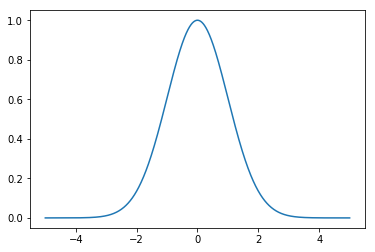

In [4]:
def exp_cov(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2))

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

Проведем эксперименты.
Зададим гауссовский процесс $(X_t, t\in\mathbb{R})$ в виде $X_t = f(t) + \sigma\varepsilon_t$, где $(\varepsilon_t, t\in\mathbb{R})$ --- гауссовский белый шум, то есть все $\varepsilon_t$ независимы и имеют стандартное нормальное распределение.

В качестве моментов времени $t_1, ..., t_n$ гененируем несколько точек на прямой.
Для начала возьмем $\sigma=0$, что соответствует отсутствию погрешности измерений.
Выполните код ниже.

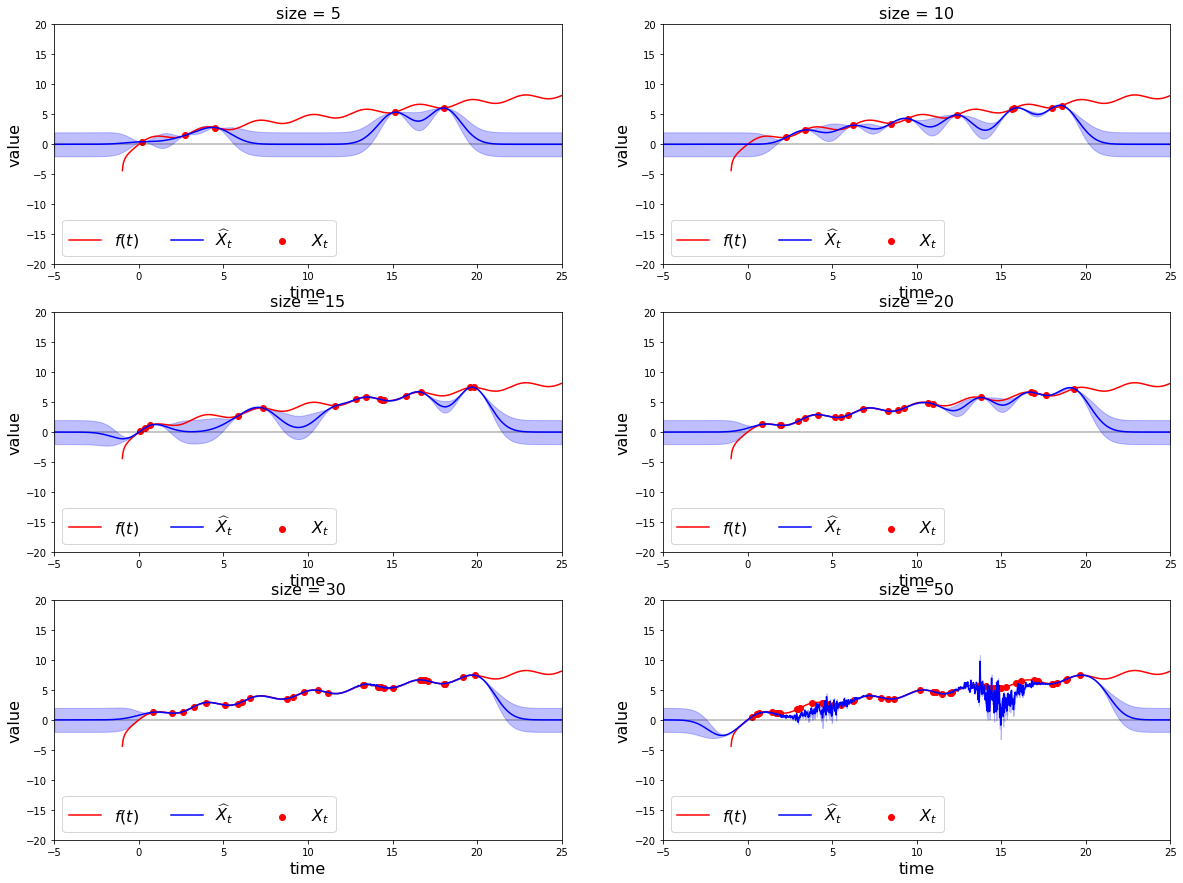

In [5]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Теперь предположим, что измерения проводятся с погрешностью, то есть $\sigma > 0$. Скопируйте код выше в новую ячейку, раскомментируйте строчку кода и запустите.

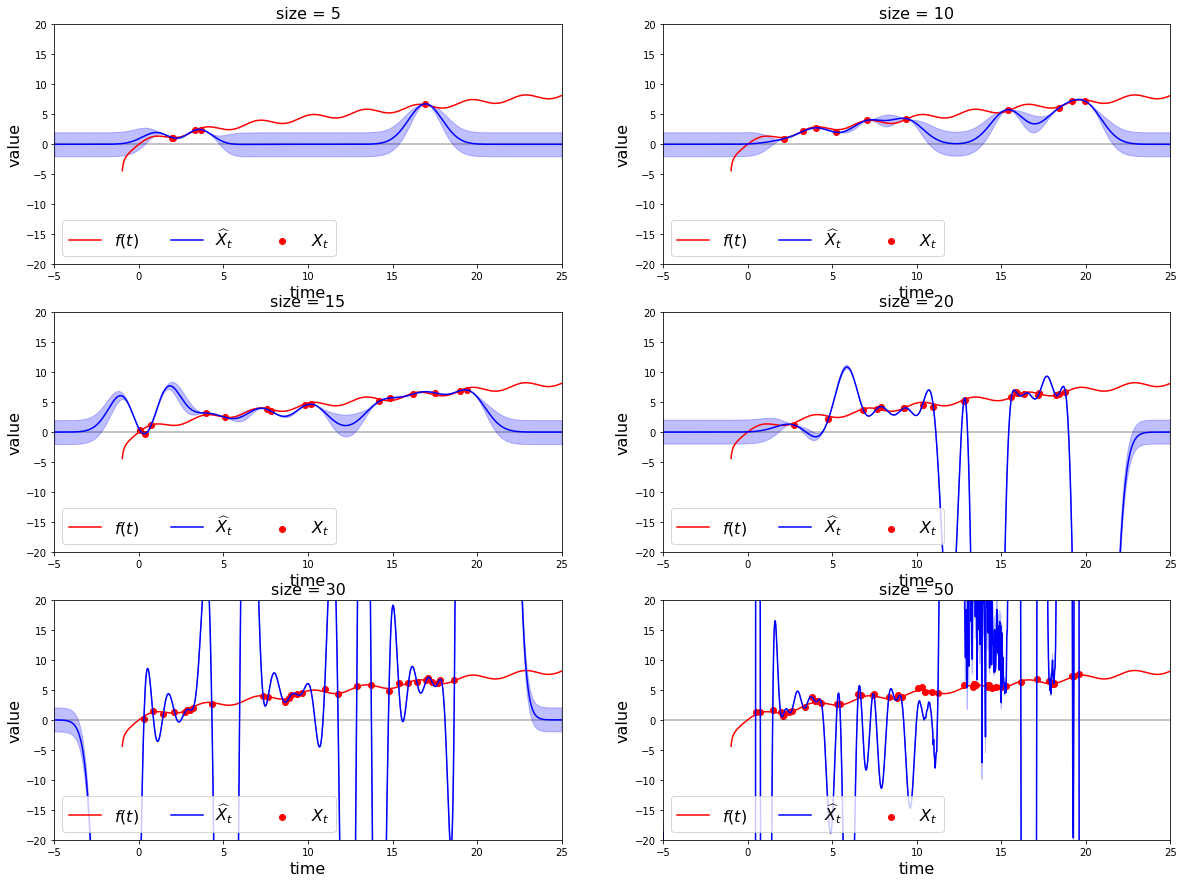

In [6]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему получается так плохо? Что нужно сделать, чтобы это исправить (обратите внимание на ковариационную функцию)?

<ответ>

Исправьте это.

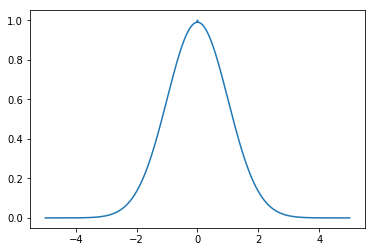

In [8]:
def exp_cov(t, a=0.99, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2)) + ((t==0).prod(axis=-1) * (1 - a))

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

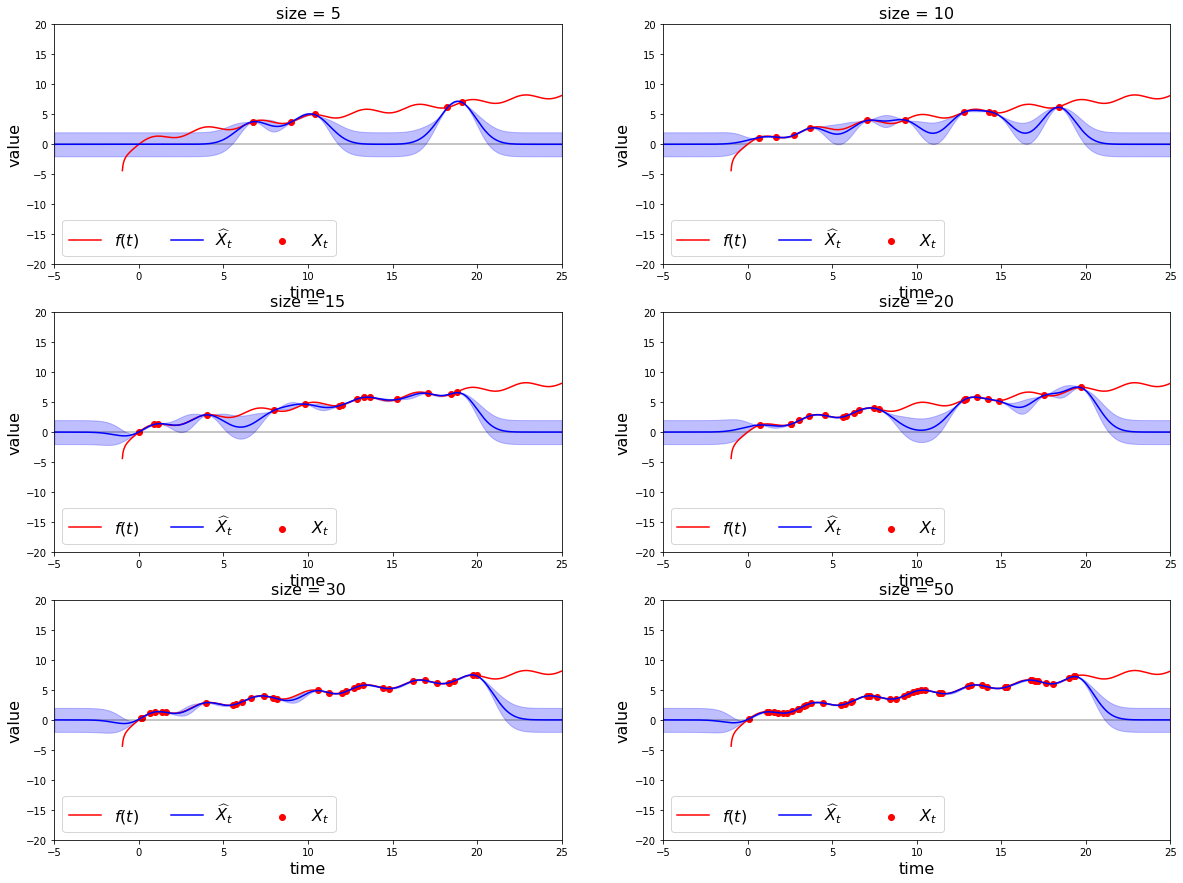

In [10]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
#     X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

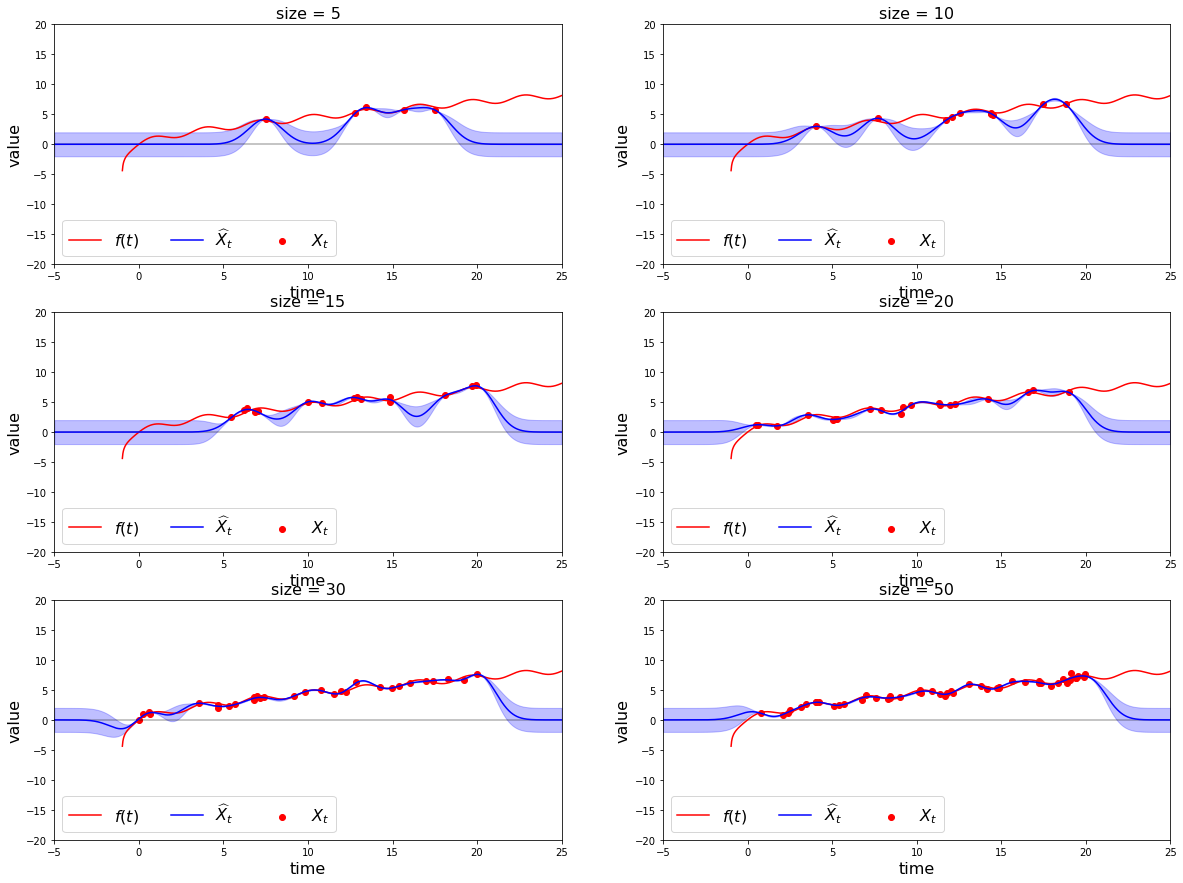

In [12]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему стало лучше?

<Ответ>

Однако, это все равно не поясняет, почему в самом первом случае (при $\sigma=0$) мог наблюдаться похожий эффект. В чем его причина?

<Ответ>

Пойдем теперь дальше. Вспомним наше предположение о том, что математическое ожидание равно нулю, хотя на самом деле это не так.
Давайте это исправим.
В примере выше перед применением регрессии вычтете среднее значение, а после --- добавьте обратно.

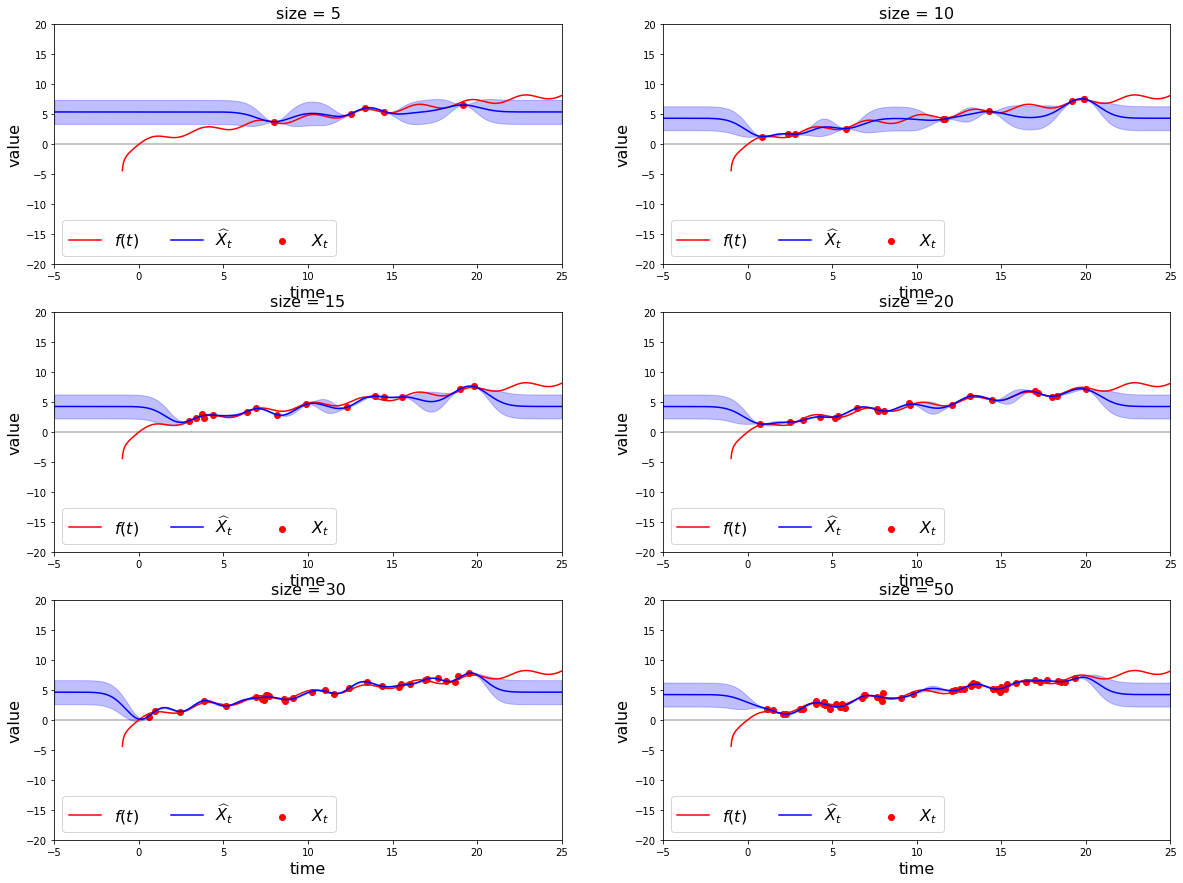

In [26]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    # Среднее сразу вычитается из X и передается в fit
    # Так не придется потом добавлять его обратно
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - np.mean(X))
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Прибавление среднего значения
    predict += np.mean(X)
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Лучше, но все равно чего-то не хватает.
Может, приблизить линейной регрессией?

Проделайте аналогичные действия, построив сначала линейную регрессию, затем вычев ее значения из точек данных перед применением регрессии на гауссовских процессах, а после --- добавив обратно значения линейной регрессии для всех точек, в которых вы хотите построить предсказания.

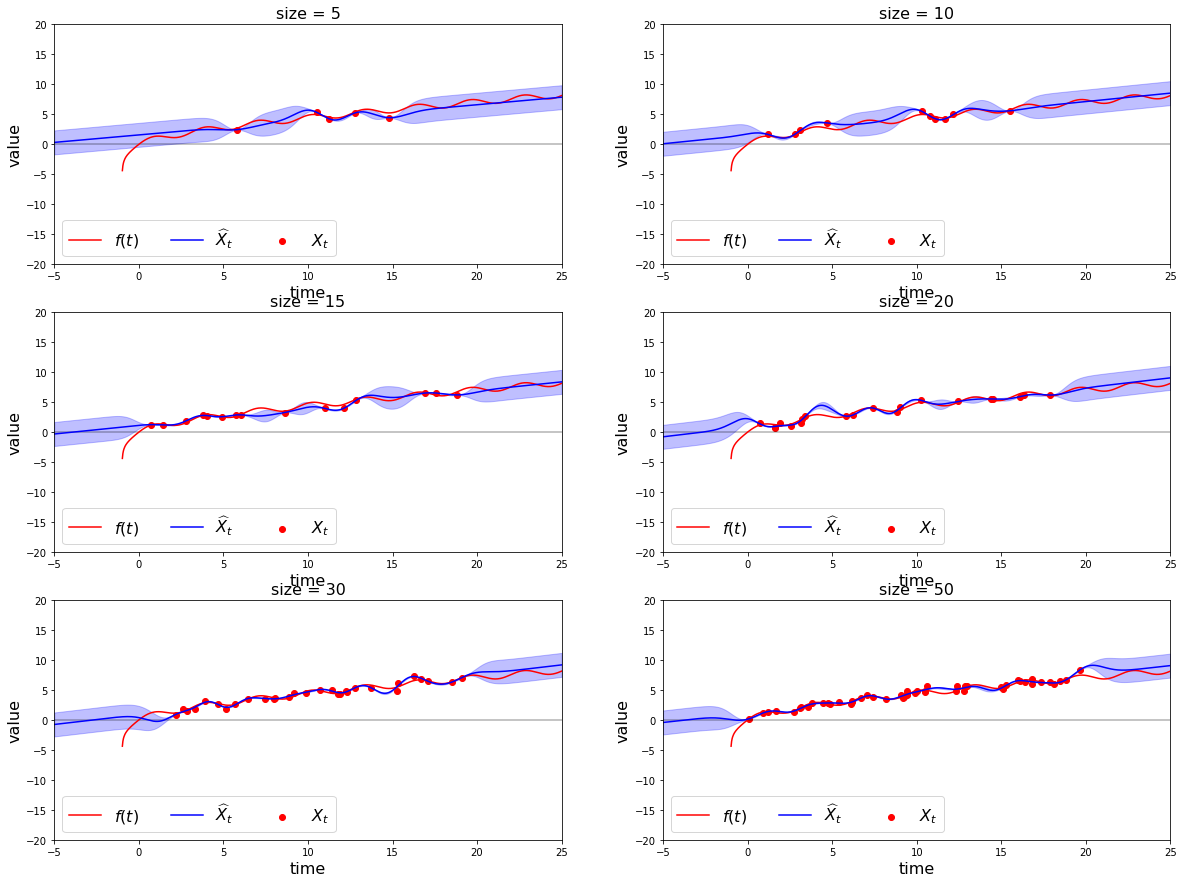

In [50]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    X += norm(0, 0.3).rvs(X.shape)

    # Линейная регрессия
    Q = T.reshape((size, 1))
    W = np.reshape(np.ones(size), (size, 1))
    A = np.hstack((Q, W))
    params = np.linalg.inv(A.T @ A) @ A.T @ X    
    additionaltest = params[0] * T + params[1]
    additionaltrain = params[0] * grid + params[1]
    
    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X - additionaltest)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    
    # Прибавление
    predict += additionaltrain
    
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Разберемся подробнее в том, что происходит.

Допустим, мы хотим приблизить простую линейную функцию.
Построим график выборки и график предсказаний с помощью линейной регрессии.
Построим так же график ошибок, то есть точек $X_{t_i} - \widehat{f}(t_i)$, где $\widehat{f}$ --- линейная регрессия.

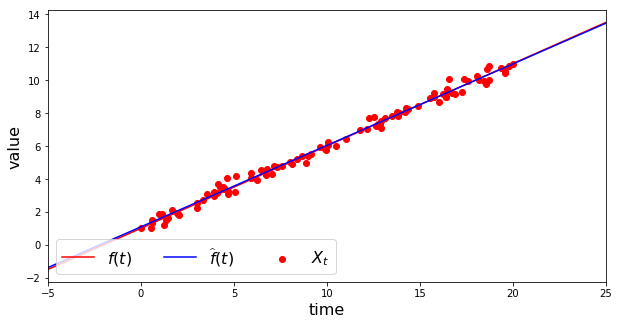

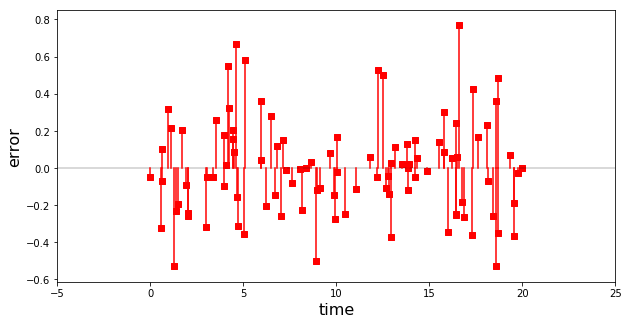

In [56]:
def f_lin(x):
    return x / 2 + 1

T = uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = f_lin(T)
X += norm(0, 0.3).rvs(X.shape)

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))

# Линейная регрессия
Q = T.reshape((100, 1))
W = np.reshape(np.ones(100), (100, 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ X
predict = params[0] * grid + params[1]

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, f_lin(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - params[0] * T[i] - params[1]], color='red')
    plt.scatter(T[i], X[i] - params[0] * T[i] - params[1], marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что можно сказать про остатки?

<Ответ>

Теперь посмотрим на функцию, с которой мы имели дело ранее.

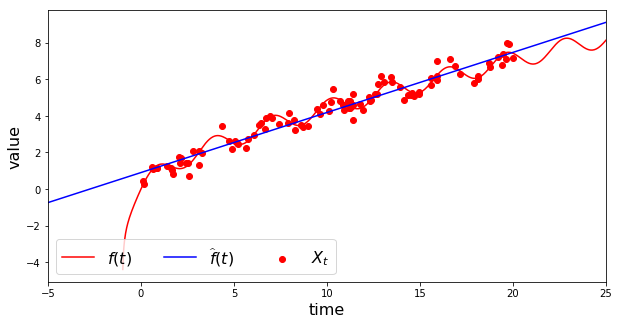

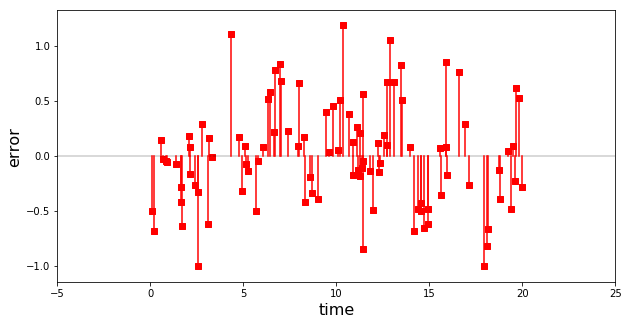

In [57]:
T = uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = calc_f(T)
X += norm(0, 0.3).rvs(X.shape)

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))

# Линейная регрессия
Q = T.reshape((100, 1))
W = np.reshape(np.ones(100), (100, 1))
A = np.hstack((Q, W))
params = np.linalg.inv(A.T @ A) @ A.T @ X
predict = params[0] * grid + params[1]

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - params[0] * T[i] - params[1]], color='red')
    plt.scatter(T[i], X[i] - params[0] * T[i] - params[1], marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что тут с остатками?

<Ответ>

Давайте приближать эту зависимость в остатках регрессией на основе гауссовских процессах.

In [ ]:
grid, predict, sigma = <...>

plt.figure(figsize=(15, 7))
plt.plot(grid, predict, color='blue')
plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                 color='blue', alpha=0.25)
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - lr.predict(T[i])], color='red')
    plt.scatter(T[i], X[i] - lr.predict(T[i]), marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.show()

Сделайте подробные выводы.

<Ответ>


Рассмотрим теперь гауссовский процесс $(X_t, t\in\mathbb{R}_+)$, заданный как $X_t = t + W_{t+1} - W_{t}$, где $(W_t, t\in\mathbb{R}_+)$ --- винеровский процесс.
Сгенерируйте данные в соответствии с этой моделью. Для генерации винеровского процесса используйте код из предыдущего задания. По этим данным постройте комбинацию линейная регрессия + регрессия на гауссовских процессах, как в примерах выше. Как и раньше, проведите эксперимент для различного объема данных.

In [ ]:
<Код и графики>

Скачайте датасет <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a>.
Задача состоит в том, чтобы для парусных яхт предсказать остаточное сопротивление на единицу массы смещения от размеров яхты и ее скорости. Рассмотрим зависимость величины `Residuary resistance` от `Froude number`. Постройте приближение этой зависимости с помощью комбинации линейной регрессии и регрессии на гауссовских процессах. Посчитайте ошибку предсказания и сравните ее с ошибкой предсказания с помощью простой линейной регрессии. Для линейной регрессии можно взять так же вторую и третью степень величины `Residuary resistance`.

Дополнительно вы можете попробовать <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process">реализацию</a> регрессии на гауссовских процессах в `sklearn`.